<a href="https://colab.research.google.com/github/thanmayeem/Harnessing-Machine-Learning-for-Reliable-Solar-Power-Generation-Forecasting/blob/main/LightGBandRandomForestPlusXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git config --global user.email "mthanmayee74@gmail.com"
!git config --global user.name "thanmayeem"

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

# Load datasets
generation_data = pd.read_csv("Plant_2_Generation_Data.csv")
weather_data = pd.read_csv("Plant_2_Weather_Sensor_Data.csv")

# Merge datasets on 'DATE_TIME' column
df_solar = pd.merge(
    generation_data.drop(columns=['PLANT_ID']),
    weather_data.drop(columns=['PLANT_ID', 'SOURCE_KEY']),
    on='DATE_TIME'
)

# Sample 10,000 rows randomly
df_solar_sample = df_solar.sample(n=10000, random_state=42)

# Set a threshold to classify yield as high or low
yield_threshold = df_solar_sample['DAILY_YIELD'].mean()
df_solar_sample['HIGH_YIELD'] = np.where(df_solar_sample['DAILY_YIELD'] >= yield_threshold, 1, 0)

# Define features and target
X = df_solar_sample[['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
y = df_solar_sample['HIGH_YIELD']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define base models
lightgbm_model = lgb.LGBMClassifier()
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define stacking model with a logistic regression meta-classifier
stacked_model = StackingClassifier(
    estimators=[
        ('lightgbm', lightgbm_model),
        ('random_forest', random_forest_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = stacked_model.predict(X_test)

# Print classification report and confusion matrix
print("Stacked Model Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Calculate error metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print error metrics
print("\nStacked Model Error Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 3253, number of negative: 3747
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464714 -> initscore=-0.141378
[LightGBM] [Info] Start training from score -0.141378
[LightGBM] [Info] Number of positive: 2603, number of negative: 2997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464821 -> initscore=-0.140947
[LightGBM] [Info] Start training from score -0.140947
[LightGBM] [Info] Nu

DC_POWER               float64
AC_POWER               float64
DAILY_YIELD            float64
TOTAL_YIELD            float64
AMBIENT_TEMPERATURE    float64
MODULE_TEMPERATURE     float64
IRRADIATION            float64
dtype: object
[0]	validation_0-rmse:2845.68523
[200]	validation_0-rmse:1319.33378
[400]	validation_0-rmse:1232.72056
[600]	validation_0-rmse:1201.63383
[800]	validation_0-rmse:1190.38191
[1000]	validation_0-rmse:1187.84542
[1200]	validation_0-rmse:1188.63221
[1287]	validation_0-rmse:1189.32226
Mean Squared Error (MSE): 1409337.7371221015
Root Mean Squared Error (RMSE): 1187.155312973876
Mean Absolute Error (MAE): 743.0931651210008
R² Score: 0.8360908188099097


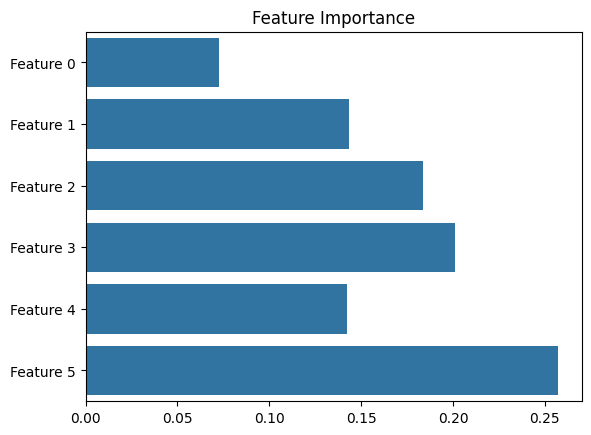

Cross-validation results:
      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         2828.122897        2.345943     2830.722597       9.797698
1         2756.881415        2.407310     2761.947198       9.978866
2         2680.446608        1.798812     2688.219838      10.303008
3         2606.385313        2.165291     2616.610527       9.829770
4         2547.979515        2.111386     2559.771297       9.484964
...               ...             ...             ...            ...
1082       623.978212        5.360146     1232.449502       7.470666
1083       623.908082        5.372218     1232.434330       7.424984
1084       623.307690        5.254023     1232.439876       7.428643
1085       623.204056        5.271183     1232.365710       7.412620
1086       623.078407        5.271609     1232.278445       7.415160

[1087 rows x 4 columns]


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
generation_data = pd.read_csv("Plant_2_Generation_Data.csv")
weather_data = pd.read_csv("Plant_2_Weather_Sensor_Data.csv")

# Merge datasets on 'DATE_TIME' column
df_solar = pd.merge(
    generation_data.drop(columns=['PLANT_ID']),
    weather_data.drop(columns=['PLANT_ID', 'SOURCE_KEY']),
    on='DATE_TIME'
)

# Drop 'SOURCE_KEY' or any non-numeric columns before scaling
df_solar = df_solar.drop(columns=['DATE_TIME', 'SOURCE_KEY'])

# Check if all columns are numeric now
print(df_solar.dtypes)

# Identify the target column (e.g., 'DAILY_YIELD')
target_column = 'DAILY_YIELD'

# Prepare your features and target
X = df_solar.drop(columns=[target_column])  # Use the actual target column name
y = df_solar[target_column]  # Use the actual target column name

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# XGBoost model setup (using XGBRegressor for regression task)
model_xgb = xgb.XGBRegressor(
    n_estimators=2000,            # Number of trees
    max_depth=10,                 # Depth of trees
    learning_rate=0.05,           # Learning rate
    subsample=0.8,                # Fraction of samples to use for training each tree
    colsample_bytree=0.8,         # Fraction of features to use for each tree
    reg_lambda=3,                 # L2 regularization term
    random_state=42,              # Random seed for reproducibility
    early_stopping_rounds=200,    # Early stopping after 200 rounds without improvement
    objective='reg:squarederror', # Squared error for regression
    eval_metric='rmse'            # Root mean squared error for evaluation
)

# Fit the model on the training data
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=200)

# Predictions on the test data
y_pred = model_xgb.predict(X_test)

# Evaluate the model using regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

# Feature importance visualization
feature_importance = model_xgb.feature_importances_
sns.barplot(x=feature_importance, y=[f"Feature {i}" for i in range(X_train.shape[1])])
plt.title('Feature Importance')
plt.show()

# Cross-validation (using xgboost cv method)
cv_results = xgb.cv(
    dtrain=xgb.DMatrix(X_train, label=y_train),
    params={
        'objective': 'reg:squarederror',  # Regression objective
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_lambda': 3,
        'eval_metric': 'rmse'  # RMSE as evaluation metric
    },
    nfold=5,                     # Number of folds for cross-validation
    num_boost_round=2000,        # Boosting rounds
    early_stopping_rounds=200,   # Early stopping
    seed=42                      # Random seed for reproducibility
)

# Print cross-validation results
print("Cross-validation results:")
print(cv_results)

# Save the trained model for later use
model_xgb.save_model("xgboost_model_best.json")

